# Test-retest reliability

In this notebook, the goal is to assess the test-retest reliability of each framework. For this, we used 289 subjects from the OASIS-3 dataset. The protocol followed in the OASIS-3 dataset, implied that at least two MRI images per subject were acquired in the same day within a 60-minute period. The two images per subject were pre-processed by both frameworks and the test-retest reliability within framework was assessed. 

In [1]:
#@title

import os
import math
import matplotlib
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.linear_model import LinearRegression
from settings import RESOURCE_DIR
from utils import get_regression_metrics, bland_altman_plot

# Tables format
pd.set_option('display.float_format', lambda x: f"{x: 0.2e}")

# Visualization format
font = {'size'   : 18}
matplotlib.rc('font', **font)
sns.set_theme(style="whitegrid", font_scale=2)

# Global variables
var_compare = "software"
template_name = "a2009s"
metric_analysis = "corticalThicknessAverage"
path_csv_cortical_data = "cortical_thicknesss_test_restest.csv"

pipeline1 = "ACPC_CAT12"
pipeline2 = "FREESURFER"

color_pallete = {pipeline1: "#365162", pipeline2: "#9C5315"}

var_analyse = ["r_square", "slope", "intercept"]



/home/fmachado/anaconda3/envs/fs-cat12/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
#@title
df_names_rois = pd.read_csv(os.path.join(RESOURCE_DIR, "template", f"{template_name}_atlas_labels.csv"))
df_areas = pd.read_csv(os.path.join(RESOURCE_DIR, "template", f"{template_name}_rois_areas.csv"))

## Data

In [3]:
#@title
df_software_raw = pd.read_csv(os.path.join(RESOURCE_DIR, "data", path_csv_cortical_data), low_memory=False)
df_software_raw.set_index("path", inplace=True)
# Get only the template ROIs
df_software_raw = df_software_raw.loc[df_software_raw.roiName.str[1:].isin(df_names_rois.label.to_list())]

df_software_raw.head(4)

repositoryName    software  \
path                                                                            
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...         OASIS3  ACPC_CAT12   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...         OASIS3  ACPC_CAT12   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...         OASIS3  ACPC_CAT12   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...         OASIS3  ACPC_CAT12   

                                                       subjectID  sessionID  \
path                                                                          
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  sub-OAS30001  ses-d0129   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  sub-OAS30001  ses-d0129   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  sub-OAS30001  ses-d0129   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  sub-OAS30001  ses-d0129   

                                                    run       age  gender  \
path                                                                        
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...    1  6.55e+01  FEMALE   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...    1  6.55e+01  FEMALE   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...    1  6.55e+01  FEMALE   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...    1  6.55e+01  FEMALE   

                                                    software.1  \
path                                                             
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  ACPC_CAT12   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  ACPC_CAT12   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  ACPC_CAT12   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  ACPC_CAT12   

                                                                     roiName  \
path                                                                           
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  lG_Ins_lg_and_S_cent_ins   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...       lG_and_S_cingul-Ant   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...   lG_and_S_cingul-Mid-Ant   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  lG_and_S_cingul-Mid-Post   

                                                    corticalThicknessAverage  \
path                                                                           
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...                  2.97e+00   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...                  2.49e+00   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...                  2.57e+00   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...                  2.39e+00   

                                                   template  cjv_run1  \
path                                                                    
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...   a2009s  4.01e-01   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...   a2009s  4.01e-01   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...   a2009s  4.01e-01   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...   a2009s  4.01e-01   

                                                    cnr_run1  snr_total_run1  \
path                                                                           
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  3.41e+00        1.04e+01   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  3.41e+00        1.04e+01   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  3.41e+00        1.04e+01   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  3.41e+00        1.04e+01   

                                                    cjv_run2  cnr_run2  \
path                                                                     
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  3.93e-01  3.42e+00   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001...  3.93e-01  3.42e+00   
OASIS3/sub-OAS30001/ses-d0129/anat/sub-OAS30001... 

### Check preprocessing problems

Some images were only ran by one of the softwares, in the code below images with preprocessing problems are discoved, and those subjects/session/run are removed from the analysis.

In [4]:
#@title
roi_name = df_software_raw.loc[(~df_software_raw[metric_analysis].isna()) & (df_software_raw.template == template_name)].roiName.to_list()[1]

df_group = df_software_raw[df_software_raw["roiName"] == roi_name].copy()
df_group = df_group[df_group.template == template_name].groupby(by=['path']).apply(lambda x: list(x["software"]))

# Get the images run by only one
df_problems_running = df_group[df_group.apply(len) == 1].to_frame()


software_problems = [item for sublist in df_problems_running[0].to_list() for item in sublist]


print("\n".join([f"{number_problems} images were only processed by: {soft_name}" for soft_name, number_problems in Counter(software_problems).items()]))

1 images were only processed by: FREESURFER


#### Exclude the subjects only run by only one software

In [5]:
#@title
df_software_raw = df_software_raw[~df_software_raw.index.isin(df_problems_running.index)]
df_software = df_software_raw.reset_index().pivot(['subjectID', 'sessionID', 'template', var_compare,'roiName'], ['run'], [metric_analysis])
df_software.head(4)

corticalThicknessAverage  \
run                                                                                        1   
subjectID    sessionID template software   roiName                                             
sub-OAS30001 ses-d0129 a2009s   ACPC_CAT12 lG_Ins_lg_and_S_cent_ins                 2.97e+00   
                                           lG_and_S_cingul-Ant                      2.49e+00   
                                           lG_and_S_cingul-Mid-Ant                  2.57e+00   
                                           lG_and_S_cingul-Mid-Post                 2.39e+00   

                                                                               
run                                                                         2  
subjectID    sessionID template software   roiName                             
sub-OAS30001 ses-d0129 a2009s   ACPC_CAT12 lG_Ins_lg_and_S_cent_ins  2.85e+00  
                                           lG_and_S_cingul-Ant       2.41e+00  
                                           lG_and_S_cingul-Mid-Ant   2.62e+00  
                                           lG_and_S_cingul-Mid-Post  2.43e+00

### Search subjects with at least one ROI NaN

In [6]:
#@title
df_rois_nan = df_software.loc[df_software[[('corticalThicknessAverage', 1), ('corticalThicknessAverage', 2)]].isna().sum(axis=1)>0]
df_rois_nan

corticalThicknessAverage  \
run                                                                                        1   
subjectID    sessionID template software   roiName                                             
sub-OAS30896 ses-d0439 a2009s   FREESURFER lS_interm_prim-Jensen                    2.13e+00   
sub-OAS30986 ses-d1188 a2009s   FREESURFER rLat_Fis-ant-Vertical                         NaN   
sub-OAS31073 ses-d0196 a2009s   ACPC_CAT12 lG_Ins_lg_and_S_cent_ins                 3.09e+00   
                                           lG_and_S_cingul-Ant                      2.35e+00   
                                           lG_and_S_cingul-Mid-Ant                  2.51e+00   
...                                                                                      ...   
                                FREESURFER rS_suborbital                            1.88e+00   
                                           rS_subparietal                           2.33e+00   
                                           rS_temporal_inf                          2.40e+00   
                                           rS_temporal_sup                          2.45e+00   
                                           rS_temporal_transverse                   2.26e+00   

                                                                               
run                                                                         2  
subjectID    sessionID template software   roiName                             
sub-OAS30896 ses-d0439 a2009s   FREESURFER lS_interm_prim-Jensen          NaN  
sub-OAS30986 ses-d1188 a2009s   FREESURFER rLat_Fis-ant-Vertical     2.27e+00  
sub-OAS31073 ses-d0196 a2009s   ACPC_CAT12 lG_Ins_lg_and_S_cent_ins       NaN  
                                           lG_and_S_cingul-Ant            NaN  
                                           lG_and_S_cingul-Mid-Ant        NaN  
...                                                                       ...  
                                FREESURFER rS_suborbital                  NaN  
                                           rS_subparietal                 NaN  
                                           rS_temporal_inf                NaN  
                                           rS_temporal_sup                NaN  
                                           rS_temporal_transverse         NaN  

[298 rows x 2 columns]

#### Exclude subjects with at least one ROI NaN

In [7]:
#@title
df_software_raw = df_software_raw.loc[~df_software_raw.subjectID.isin(df_rois_nan.index.get_level_values(0).to_list())]
df_software = df_software.loc[~df_software.index.get_level_values(0).isin(df_rois_nan.index.get_level_values(0).to_list())]
df_software

corticalThicknessAverage  \
run                                                                                        1   
subjectID    sessionID template software   roiName                                             
sub-OAS30001 ses-d0129 a2009s   ACPC_CAT12 lG_Ins_lg_and_S_cent_ins                 2.97e+00   
                                           lG_and_S_cingul-Ant                      2.49e+00   
                                           lG_and_S_cingul-Mid-Ant                  2.57e+00   
                                           lG_and_S_cingul-Mid-Post                 2.39e+00   
                                           lG_and_S_frontomargin                    2.11e+00   
...                                                                                      ...   
sub-OAS31172 ses-d0407 a2009s   FREESURFER rS_suborbital                            2.16e+00   
                                           rS_subparietal                           2.09e+00   
                                           rS_temporal_inf                          2.31e+00   
                                           rS_temporal_sup                          2.32e+00   
                                           rS_temporal_transverse                   1.80e+00   

                                                                               
run                                                                         2  
subjectID    sessionID template software   roiName                             
sub-OAS30001 ses-d0129 a2009s   ACPC_CAT12 lG_Ins_lg_and_S_cent_ins  2.85e+00  
                                           lG_and_S_cingul-Ant       2.41e+00  
                                           lG_and_S_cingul-Mid-Ant   2.62e+00  
                                           lG_and_S_cingul-Mid-Post  2.43e+00  
                                           lG_and_S_frontomargin     2.09e+00  
...                                                                       ...  
sub-OAS31172 ses-d0407 a2009s   FREESURFER rS_suborbital             1.90e+00  
                                           rS_subparietal            2.03e+00  
                                           rS_temporal_inf           2.29e+00  
                                           rS_temporal_sup           2.32e+00  
                                           rS_temporal_transverse    2.28e+00  

[87616 rows x 2 columns]

### Demographics

In [8]:
#@title
df_subjects = df_software_raw[["repositoryName", "subjectID", "sessionID", "run", "age", "snr_total_mean", "gender"]].drop_duplicates().copy()


groupby_col = ["repositoryName"]
    
df_summary = df_subjects.groupby(groupby_col).apply(lambda x: pd.Series({"Total of participants": len(x), 
                                                                         "Number males": (x["gender"]=="MALE").sum(),
                                                                         "Mean and standard deviation [years]": f"{x['age'].mean(): 0.2f}+/-{x['age'].std(): 0.2f}",
                                                                         "Min Age [years]": f"{x['age'].min(): 0.2f}",
                                                                         "Max Age [years]": f"{x['age'].max(): 0.2f}"}))


df_ct = df_software.reset_index()[["subjectID", var_compare, "roiName", "corticalThicknessAverage"]].melt(id_vars=["subjectID", var_compare, "roiName"])

df_summary

Total of participants  Number males  \
repositoryName                                        
OASIS3                            592           222   

               Mean and standard deviation [years] Min Age [years]  \
repositoryName                                                       
OASIS3                               68.94+/- 8.85           45.78   

               Max Age [years]  
repositoryName                  
OASIS3                   88.86

## Analysis

### Overall Analysis

#### Bland-Altman plot

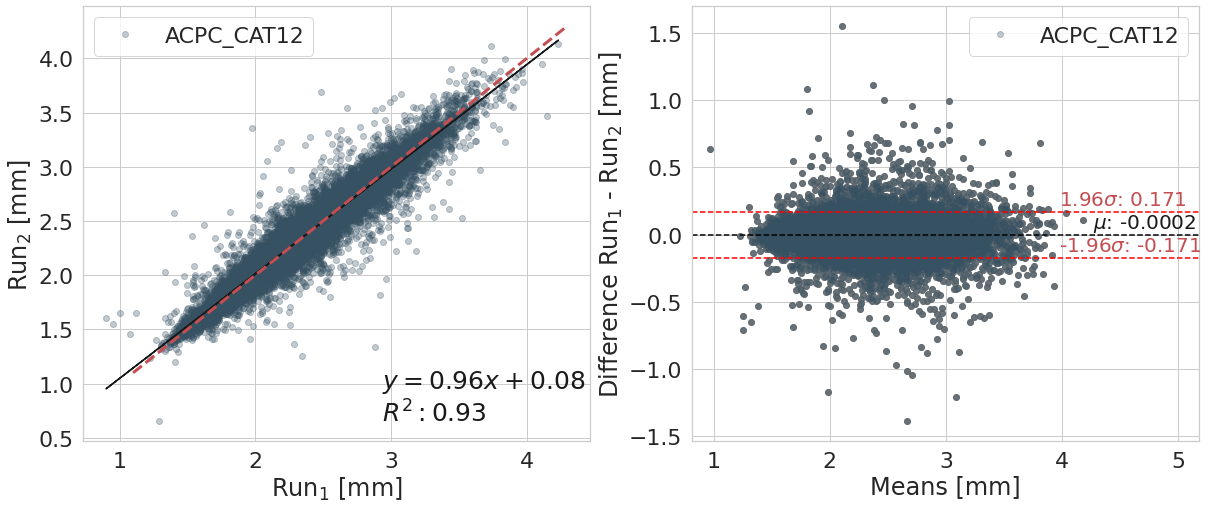

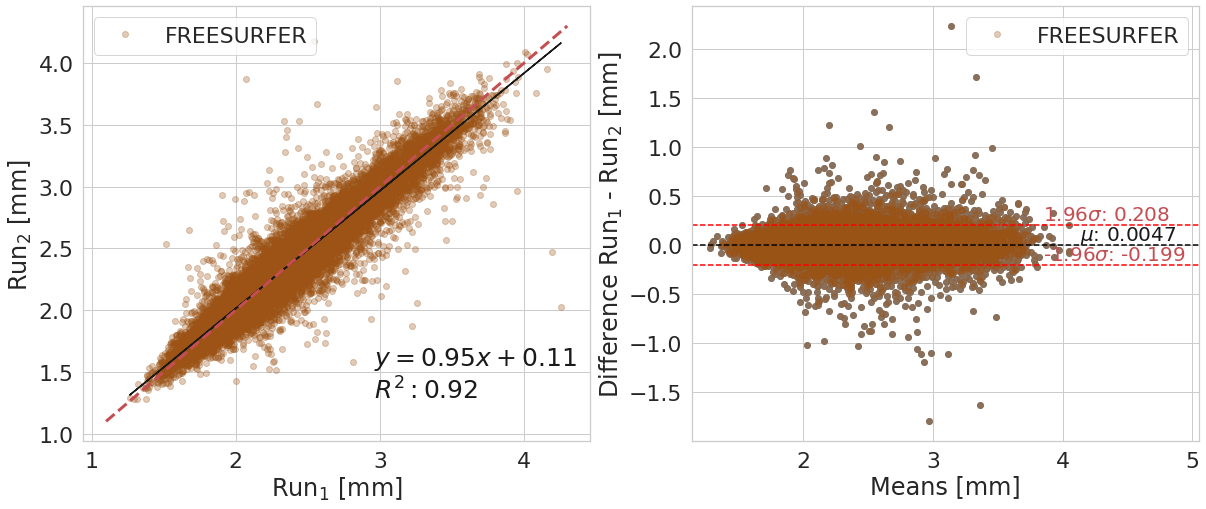

In [9]:
#@title
y_label_txt = "Difference Run$_1$ - Run$_2$ [mm]"


for var in df_software.index.get_level_values(3).unique():
    df_filt = df_software.loc[df_software.index.get_level_values(3) == var]


    bland_altman_plot(df_filt.copy().reset_index(),
                      ('corticalThicknessAverage', 1), 
                      ('corticalThicknessAverage', 2),
                      var_compare, color_pallete, x_label_reg='Run$_1$ [mm]', y_label_reg='Run$_2$ [mm]',
                      y_label_diff=y_label_txt)
    


In [10]:
from IPython.display import display, HTML

df_means = []
for soft in ['ACPC_CAT12', 'FREESURFER']:
    df_soft_filter = df_software.loc[df_software.index.get_level_values(3) == soft]
    diff = df_soft_filter[("corticalThicknessAverage", 1)] - df_soft_filter[("corticalThicknessAverage", 2)]
    df_means_diff = df_soft_filter[[("corticalThicknessAverage", 1), ("corticalThicknessAverage", 2)]].mean().to_frame().T.rename(columns={"corticalThicknessAverage": "Cortical Thickness Average Mean"})
    df_means_diff["Difference Run1 - Run 2"] = diff.mean()
    
    
    test = pg.ttest(diff, 0)
    display(HTML(f"<br><h5>{soft}</h5>"))
    display(HTML(df_means_diff.to_html()))
    
    display(HTML(f"<br><p>One sample t-test to verify whether the means difference is equal to zero</p>"))
    display(HTML(test.to_html()))
    print(f"Confidence interval (95%) of the means difference: [{round(diff.mean() - 1.96*diff.std(), 3)};{round(diff.mean() + 1.96*diff.std(), 3)}]")


Confidence interval (95%) of the means difference: [-0.171;0.171]


Confidence interval (95%) of the means difference: [-0.199;0.208]


### Participant Analysis

In [11]:
#@title
print(f'Number of subjects in this analysis is: {len(df_software.reset_index()["subjectID"].unique())}')

Number of subjects in this analysis is: 296


#### Compute metrics 

In [12]:
#@title

all_subjects_icc = []
for var in df_ct[var_compare].unique():
    for subject in df_ct["subjectID"].unique():
        df_icc_roi = pg.intraclass_corr(data=df_ct.loc[(df_ct["subjectID"] == subject) & (df_ct[var_compare] == var)], 
                                        targets='roiName', raters='run',
                                        ratings='value')
        df_icc_roi["subjectID"] = subject
        df_icc_roi[var_compare] = var
        
        all_subjects_icc.append(df_icc_roi.loc[df_icc_roi["Type"]=="ICC3"])
        
df_icc_sub = pd.concat(all_subjects_icc)


sub_grouped_by, sub_grouped_by_stats = get_regression_metrics(df_software, ['subjectID', 'sessionID', var_compare], (metric_analysis, 1), 
                                                              (metric_analysis, 2))


sub_grouped_by_stats = sub_grouped_by_stats.reset_index().set_index(["subjectID", "software"]).join(df_icc_sub.set_index(["subjectID", "software"])[["ICC"]])
sub_grouped_by_stats = sub_grouped_by_stats.reset_index().set_index(["subjectID", "sessionID", var_compare])


df_subject_info = df_subjects.loc[df_subjects["run"] ==1].reset_index().set_index(['subjectID', 'sessionID']).join(sub_grouped_by_stats)
df_subject_info = df_subject_info[~df_subject_info["slope"].isna()]


df_mean_runs = df_software.mean(axis=1).reset_index().rename(columns={0: "corticalThicknessAverage"})

df_ct_mean_runs = df_mean_runs.reset_index()[["subjectID", var_compare, "roiName", "corticalThicknessAverage"]].melt(id_vars=["subjectID", var_compare, "roiName"])

all_subjects_icc_mean_runs = []

for subject in df_ct["subjectID"].unique():
    df_icc_roi_mean_runs = pg.intraclass_corr(data=df_ct_mean_runs.loc[df_ct_mean_runs["subjectID"] == subject], 
                                    targets='roiName', raters='software',
                                    ratings='value')
    df_icc_roi_mean_runs["subjectID"] = subject
    df_icc_roi_mean_runs[var_compare] = var

    all_subjects_icc_mean_runs.append(df_icc_roi_mean_runs.loc[df_icc_roi_mean_runs["Type"]=="ICC3"])
        
df_icc_sub_mean_runs = pd.concat(all_subjects_icc_mean_runs)

df_ct_means = df_mean_runs.reset_index().pivot_table(values="corticalThicknessAverage", columns="software", 
                                                     index=["subjectID", "sessionID", "template", "roiName"])
sub_grouped_by_mean_runs, sub_grouped_by_stats_mean_runs = get_regression_metrics(df_ct_means, ['subjectID', 'sessionID'], 
                                                                                  "ACPC_CAT12", "FREESURFER")


sub_grouped_by_stats_mean_runs = sub_grouped_by_stats_mean_runs.reset_index().set_index(["subjectID"]).join(df_icc_sub_mean_runs.set_index(["subjectID"])[["ICC"]])
sub_grouped_by_stats_mean_runs = sub_grouped_by_stats_mean_runs.reset_index().set_index(["subjectID", "sessionID"])

sub_grouped_by_stats_mean_runs.head(10)


slope  intercept   r_value   p_value   std_err  \
subjectID    sessionID                                                      
sub-OAS30001 ses-d0129  9.34e-01   2.16e-01  8.12e-01  5.31e-36  5.55e-02   
sub-OAS30003 ses-d0558  9.17e-01   2.64e-01  8.12e-01  5.66e-36  5.45e-02   
sub-OAS30004 ses-d1101  8.73e-01   3.13e-01  7.88e-01  1.46e-32  5.64e-02   
sub-OAS30007 ses-d0061  9.56e-01   7.94e-02  8.44e-01  2.78e-41  5.03e-02   
sub-OAS30008 ses-d0061  9.82e-01   6.48e-02  8.45e-01  1.74e-41  5.15e-02   
sub-OAS30009 ses-d0148  9.90e-01   8.28e-03  8.01e-01  2.24e-34  6.12e-02   
sub-OAS30014 ses-d0196  8.89e-01   3.07e-01  8.40e-01  1.39e-40  4.76e-02   
sub-OAS30015 ses-d0116  8.80e-01   2.86e-01  7.88e-01  1.63e-32  5.69e-02   
sub-OAS30017 ses-d0054  9.85e-01   5.89e-02  8.58e-01  4.69e-44  4.88e-02   
sub-OAS30018 ses-d0070  1.02e+00   4.25e-02  7.82e-01  8.69e-32  6.69e-02   

                        r_square       ICC  
subjectID    sessionID                      
sub-OAS30001 ses-d0129  6.60e-01  8.04e-01  
sub-OAS30003 ses-d0558  6.59e-01  8.06e-01  
sub-OAS30004 ses-d1101  6.21e-01  7.84e-01  
sub-OAS30007 ses-d0061  7.12e-01  8.37e-01  
sub-OAS30008 ses-d0061  7.14e-01  8.35e-01  
sub-OAS30009 ses-d0148  6.42e-01  7.84e-01  
sub-OAS30014 ses-d0196  7.05e-01  8.39e-01  
sub-OAS30015 ses-d0116  6.20e-01  7.83e-01  
sub-OAS30017 ses-d0054  7.36e-01  8.50e-01  
sub-OAS30018 ses-d0070  6.12e-01  7.56e-01

#### Test-retest metrics analysis

In [33]:
#@title
df_subject_info.groupby(by=var_compare).apply(lambda x: pd.Series([f'{x["ICC"].mean(): 0.2f}+/-{x["ICC"].std(): 0.2f}',
                                                                   f'{x["r_square"].mean(): 0.2f}+/-{x["r_square"].std(): 0.2f}'], 
                                                                   index=['ICC', '$R^2$']))

ICC          $R^2$
software                                
ACPC_CAT12   0.97+/- 0.04   0.94+/- 0.06
FREESURFER   0.96+/- 0.04   0.93+/- 0.07

##### Statistical analysis -- Paired t-test

In [35]:
df_sub_t = df_subject_info.reset_index()

for var in ["ICC", "r_square"]:

    df_result = pg.ttest(df_sub_t.loc[df_sub_t["software"] == "ACPC_CAT12"][var], 
                         df_sub_t.loc[df_sub_t["software"] == "FREESURFER"][var], paired = True)
    
    display(HTML(f"<br><p>{var}</p>"))
    display(HTML(df_result.to_html()))
    

In [15]:
def latex_float(float_str):
    
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

#### Analysis of age effect on test-retest metrics

<IPython.core.display.Math object>

<IPython.core.display.Math object>

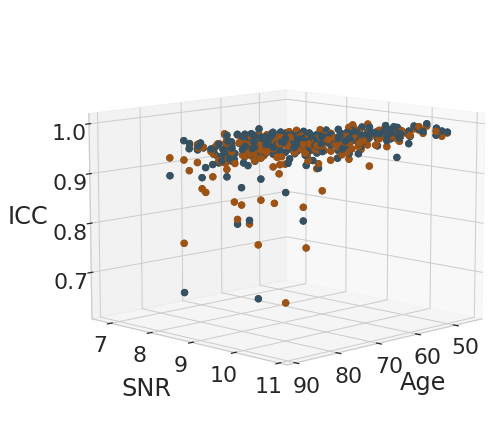

<IPython.core.display.Math object>

<IPython.core.display.Math object>

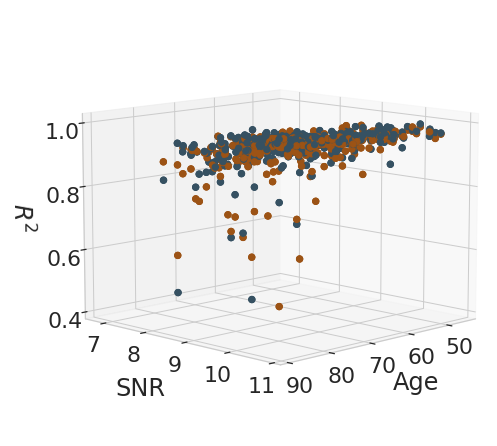

In [19]:
from IPython.display import display, Math

import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

reliability_measures = [("ICC", "ICC"), ("r_square", "$R^2$")]

for rel_measure, label_measure in reliability_measures:
    for el in df_subject_info.index.get_level_values(2).unique():
        legend = el
        if legend == "ACPC_CAT12":
            legend = "CAT12"
            
        data_filtered = df_subject_info.loc[df_subject_info.index.get_level_values(2) == el]
                
        x_values = data_filtered[["age", "snr_total_mean"]]
        y_values = data_filtered[rel_measure]
        
        model = LinearRegression().fit(x_values, y_values)

        
        age_weight = latex_float(f'{model.coef_[0]: 0.1e}')
        SNR_weight = latex_float(f'{model.coef_[1]: 0.1e}')
        intercept = latex_float(f'{model.intercept_: 0.1e}')
        
        eq = f'${label_measure.replace("$", "")}_' + "{" + legend + "}" + f'={age_weight}age + {SNR_weight}SNR + {intercept}$'
        display(Math(r'{}'.format(eq)))
        
        
    x= df_subject_info["age"].values
    y= df_subject_info["snr_total_mean"].values
    z= df_subject_info[rel_measure].values

    # axes instance
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

    # plot
    sc = ax.scatter(x, y, z, s=40, c=[color_pallete[el] for el in df_subject_info.index.get_level_values(2).values], marker='o', cmap=cmap, alpha=1)
    sc = ax.scatter(x, y, z, s=40, c=[color_pallete[el] for el in df_subject_info.index.get_level_values(2).values], marker='o', cmap=cmap, alpha=1)

    ax.set_xlabel('Age', labelpad=15)
    ax.set_ylabel('SNR', labelpad=20)
    ax.set_zlabel(label_measure, labelpad=15)

    ax.view_init(elev=10., azim=45)

    plt.subplots_adjust(bottom=0.2, top=2)

    plt.show()

#### Reproducibility considering the mean of two runs

In [20]:
sub_grouped_by_stats_mean_runs.apply(lambda x: f"{round(x.mean(), 2)} +/- {round(x.std(), 2)}")[["r_square", "ICC"]].to_frame()

0
r_square  0.67 +/- 0.07
ICC       0.81 +/- 0.06

### ROI Analysis

#### Compute metrics 

In [22]:
#@title

roi_grouped_by, roi_grouped_by_stats = get_regression_metrics(df_software, ["roiName", var_compare], 
                                                              (metric_analysis, 1), 
                                                              (metric_analysis, 2))

all_rois = []
df_ct = df_software.reset_index()[["subjectID", var_compare, "roiName", "corticalThicknessAverage"]].melt(id_vars=["subjectID", var_compare, "roiName"])

for var in df_ct[var_compare].unique():
    for roi_name in df_ct["roiName"].unique():
        df_icc_roi = pg.intraclass_corr(data=df_ct.loc[(df_ct["roiName"] == roi_name) & (df_ct[var_compare] == var)], 
                                        targets='subjectID', raters='run',
                                        ratings='value')
        df_icc_roi["roiName"] = roi_name
        df_icc_roi[var_compare] = var
        
        all_rois.append(df_icc_roi.loc[df_icc_roi["Type"]=="ICC3"])
        
df_icc_rois = pd.concat(all_rois)


roi_grouped_by_stats = roi_grouped_by_stats.join(pd.concat(all_rois).set_index(["roiName", var_compare])[["ICC", "CI95%"]])

map_abbrev_to_name = df_names_rois.set_index("label")[["name"]].to_dict("series")["name"]
hem_label = {"r": "Right", "l": "Left"}

roi_grouped_by_stats["name"] = roi_grouped_by_stats.index.to_frame().roiName.apply(lambda x: map_abbrev_to_name[x[1:]])
roi_grouped_by_stats["hem"] = roi_grouped_by_stats.index.to_frame().roiName.apply(lambda x: hem_label[x[0].lower()])

roi_melted = roi_grouped_by_stats.reset_index()[[var_compare, 'r_square', 'ICC', 'CI95%', 'name', 'hem']].melt(id_vars=[var_compare, 'name', 'hem'])

df_sorted_r2_icc = pd.pivot_table(roi_melted, index="name", values=["value"], columns=[var_compare, "hem", "variable"])


dfs = []

rois_info = roi_grouped_by_stats.copy()
rois_info["label"] = roi_grouped_by_stats.index.get_level_values(0).str[1:].str.strip()
rois_info["hem"] = roi_grouped_by_stats.index.get_level_values(0).str[0]
rois_info = rois_info.reset_index().set_index(["label", "hem", var_compare])

for var in rois_info.index.get_level_values(2).unique():
    for hem in rois_info.index.get_level_values(1).unique():
        df_areas_metrics_var = pd.concat([df_areas, df_areas["Label"].apply(lambda x: rois_info.loc[(x, hem, var)])], axis=1)
        df_areas_metrics_var[var_compare] = var
        dfs.append(df_areas_metrics_var)
df_areas_metrics = pd.concat(dfs)
df_areas_metrics["hem"] = df_areas_metrics["roiName"].str[0]


df_r2 = df_areas_metrics.pivot_table(index="name", columns=["software", "hem"], values=["r_square"])

df_icc = df_areas_metrics.pivot_table(index="name", columns=["software", "hem"], values=["ICC"])
df_ci = df_areas_metrics.pivot_table(index="name", columns=["software", "hem"], values=["CI95%"])

df_ci_icc = df_icc.join(df_ci) 
df_ci_icc.columns = df_ci_icc.columns.swaplevel(0, 2)
df_ci_icc.columns = df_ci_icc.columns.swaplevel(0, 1)
df_ci_icc = df_ci_icc[[df_ci_icc.columns[0], df_ci_icc.columns[-4], 
                     df_ci_icc.columns[1], df_ci_icc.columns[-3], 
                     df_ci_icc.columns[2], df_ci_icc.columns[-2], 
                     df_ci_icc.columns[3], df_ci_icc.columns[-1]]] 

roi_grouped_by_stats

slope  intercept   r_value    p_value  \
roiName                  software                                               
lG_Ins_lg_and_S_cent_ins ACPC_CAT12  7.42e-01   7.82e-01  7.70e-01   2.36e-59   
                         FREESURFER  7.57e-01   7.19e-01  8.03e-01   3.85e-68   
lG_and_S_cingul-Ant      ACPC_CAT12  8.40e-01   4.09e-01  9.15e-01  7.91e-118   
                         FREESURFER  8.27e-01   4.42e-01  8.29e-01   3.69e-76   
lG_and_S_cingul-Mid-Ant  ACPC_CAT12  9.43e-01   1.52e-01  9.59e-01  1.39e-163   
...                                       ...        ...       ...        ...   
rS_temporal_inf          FREESURFER  8.18e-01   4.29e-01  8.66e-01   2.29e-90   
rS_temporal_sup          ACPC_CAT12  9.44e-01   1.38e-01  9.38e-01  4.18e-137   
                         FREESURFER  8.84e-01   2.78e-01  9.00e-01  5.36e-108   
rS_temporal_transverse   ACPC_CAT12  8.88e-01   2.37e-01  8.77e-01   9.65e-96   
                         FREESURFER  8.27e-01   3.83e-01  8.41e-01   1.42e-80   

                                      std_err  r_square       ICC  \
roiName                  software                                   
lG_Ins_lg_and_S_cent_ins ACPC_CAT12  3.58e-02  5.93e-01  7.70e-01   
                         FREESURFER  3.27e-02  6.45e-01  8.02e-01   
lG_and_S_cingul-Ant      ACPC_CAT12  2.16e-02  8.37e-01  9.12e-01   
                         FREESURFER  3.26e-02  6.87e-01  8.29e-01   
lG_and_S_cingul-Mid-Ant  ACPC_CAT12  1.62e-02  9.20e-01  9.59e-01   
...                                       ...       ...       ...   
rS_temporal_inf          FREESURFER  2.76e-02  7.49e-01  8.64e-01   
rS_temporal_sup          ACPC_CAT12  2.04e-02  8.79e-01  9.38e-01   
                         FREESURFER  2.50e-02  8.10e-01  9.00e-01   
rS_temporal_transverse   ACPC_CAT12  2.83e-02  7.70e-01  8.77e-01   
                         FREESURFER  3.10e-02  7.08e-01  8.41e-01   

                                            CI95%  \
roiName                  software                   
lG_Ins_lg_and_S_cent_ins ACPC_CAT12  [0.72, 0.81]   
                         FREESURFER  [0.76, 0.84]   
lG_and_S_cingul-Ant      ACPC_CAT12  [0.89, 0.93]   
                         FREESURFER  [0.79, 0.86]   
lG_and_S_cingul-Mid-Ant  ACPC_CAT12  [0.95, 0.97]   
...                                           ...   
rS_temporal_inf          FREESURFER  [0.83, 0.89]   
rS_temporal_sup          ACPC_CAT12  [0.92, 0.95]   
                         FREESURFER  [0.88, 0.92]   
rS_temporal_transverse   ACPC_CAT12   [0.85, 0.9]   
                         FREESURFER   [0.8, 0.87]   

                                                                                  name  \
roiName                  software                                                        
lG_Ins_lg_and_S_cent_ins ACPC_CAT12  Long insular gyrus and central sulcus of the i...   
                         FREESURFER  Long insular gyrus and central sulcus of the i...   
lG_and_S_cingul-Ant      ACPC_CAT12   Anterior part of the cingulate gyrus and sulcus    
                         FREESURFER   Anterior part of the cingulate gyrus and sulcus    
lG_and_S_cingul-Mid-Ant  ACPC_CAT12  Middle-anterior part of the cingulate gyrus an...   
...                                                                                ...   
rS_temporal_inf          FREESURFER                           Inferior temporal sulcus   
rS_temporal_sup          ACPC_CAT12                          Superior temporal sulcus    
                         FREESURFER                          Superior temporal sulcus    
rS_temporal_transverse   ACPC_CAT12                         Transverse temporal sulcus   
                         FREESURFER                         Transverse temporal sulcus   

                                       hem  
roiName                  software           
lG_Ins_lg_and_S_cent_ins ACPC_CAT12   Left  
                         FREESURFER   Left  
lG_and_S_cingul-Ant      ACPC_CAT12   Left  
  

#### Test-retest metrics analysis

In [23]:
#@title
roi_grouped_by_stats.groupby(by=var_compare).apply(lambda x: pd.Series([f'{x["ICC"].mean(): 0.2f}+/-{x["ICC"].std(): 0.2f}',
                                                                        f'{x["r_square"].mean(): 0.2f}+/-{x["r_square"].std(): 0.2f}'], 
                                                                        index=['ICC', '$R^2$']))


ICC          $R^2$
software                                
ACPC_CAT12   0.88+/- 0.05   0.78+/- 0.09
FREESURFER   0.84+/- 0.06   0.70+/- 0.10

In [24]:
df_roi_t = roi_grouped_by_stats.reset_index()

for var in ["r_square", "ICC"]:

    df_result = pg.ttest(df_roi_t.loc[df_roi_t["software"] == "ACPC_CAT12"][var], 
                         df_roi_t.loc[df_roi_t["software"] == "FREESURFER"][var], paired = True)
    
    display(HTML(f"<br><h5>{var}</h5>"))
    display(HTML(df_result.to_html()))
    


##### Mean per lobe

In [25]:
#@title

pd.set_option('display.float_format', lambda x: f"{x: 0.2f}")
to_group_by = ["Area"]
df_areas_metrics_grouped = df_areas_metrics.groupby(to_group_by + [var_compare, "hem"]).mean()
df_lobes = pd.pivot_table(df_areas_metrics_grouped.reset_index(), index=to_group_by, values=["r_square"], columns=[var_compare])

df_lobes

r_square           
software                      ACPC_CAT12 FREESURFER
Area                                               
 Frontal Lobe                       0.76       0.63
 Insula                             0.77       0.72
 Limbic lobe                        0.77       0.72
 Parietal lobe                      0.83       0.73
 Temporal and occipital lobes       0.80       0.77

#### Paired t-test

In [26]:
#@title

all_df = []
for var in df_ct[var_compare].unique():
    for roiname in df_ct['roiName'].unique():
        df_posthoc = pg.pairwise_ttests(data=df_ct.loc[(df_ct['roiName'] == roiname) & (df_ct[var_compare] == var)], 
                                        dv='value', within='run', subject='subjectID',
                                     parametric=True, padjust='fdr_bh', effsize='cohen')

        # Pretty printing of table
        df_posthoc['roiName'] = roiname
        df_posthoc[var_compare] = var
        all_df.append(df_posthoc)
df_f_p_value = pd.concat(all_df)
df_f_p_value.head(4)

Contrast  A  B  Paired  Parametric     T     dof alternative  p-unc   BF10  \
0      run  1  2    True        True -0.41  295.00   two-sided   0.68  0.071   
0      run  1  2    True        True -0.64  295.00   two-sided   0.52   0.08   
0      run  1  2    True        True -1.21  295.00   two-sided   0.23  0.135   
0      run  1  2    True        True  0.13  295.00   two-sided   0.89  0.066   

   cohen                   roiName    software  
0  -0.02  lG_Ins_lg_and_S_cent_ins  ACPC_CAT12  
0  -0.02       lG_and_S_cingul-Ant  ACPC_CAT12  
0  -0.02   lG_and_S_cingul-Mid-Ant  ACPC_CAT12  
0   0.00  lG_and_S_cingul-Mid-Post  ACPC_CAT12

In [27]:
#@title

from scipy.stats import ttest_rel

df_f_p_value["hem"] = df_f_p_value.apply(lambda x: hem_label[x.roiName[0].lower()], axis=1)
df_f_p_value["name"] = df_f_p_value.apply(lambda x: map_abbrev_to_name[x.roiName[1:]], axis=1)

# Bonferroni correction
significance_level = .05

df_f_p_value["p-value"] = df_f_p_value["p-unc"].apply(lambda x: min(x*df_f_p_value.shape[0], 1))
df_f_p_value_rejected = df_f_p_value[df_f_p_value["p-value"] < significance_level]

df_f_p_value["cohen-p-value"] = df_f_p_value[["p-value", "cohen"]].apply(lambda x: f'{x["cohen"]: 0.1}*' if x['p-value'] < significance_level else f'{x["cohen"]: 0.1}', axis=1).astype(str)

df_p_value = pd.pivot_table(df_f_p_value.reset_index(), index="name", values=["cohen-p-value"], columns=[var_compare, "hem"], aggfunc=lambda x: ' '.join(x))
df_p_value


cohen-p-value           \
software                                              ACPC_CAT12            
hem                                                         Left    Right   
name                                                                        
Angular gyrus                                              -0.01   0.0008   
Anterior occipital sulcus and preoccipital notch          -0.007    -0.02   
Anterior part of the cingulate gyrus and sulcus            -0.02    -0.05   
Anterior segment of the circular sulcus of the ...         -0.02    -0.05   
Anterior transverse collateral sulcus                       0.06     0.05   
...                                                          ...      ...   
Temporal pole                                               0.06     0.04   
Transverse frontopolar gyri and sulci                      -0.02    0.004   
Transverse temporal sulcus                                 -0.01    -0.01   
Triangular part of the inferior frontal gyrus              -0.04    -0.03   
Vertical ramus of the anterior segment of the l...         0.003     0.02   

                                                                      
software                                           FREESURFER         
hem                                                      Left  Right  
name                                                                  
Angular gyrus                                          -0.008  -0.02  
Anterior occipital sulcus and preoccipital notch         0.02  -0.02  
Anterior part of the cingulate gyrus and sulcus         0.007  -0.01  
Anterior segment of the circular sulcus of the ...       0.04   0.03  
Anterior transverse collateral sulcus                    0.07   0.08  
...                                                       ...    ...  
Temporal pole                                             0.1    0.1  
Transverse frontopolar gyri and sulci                  -0.004   0.02  
Transverse temporal sulcus                               0.01   0.05  
Triangular part of the inferior frontal gyrus            0.01   0.02  
Vertical ramus of the anterior segment of the l...        0.1   0.01  

[74 rows x 4 columns]

In [28]:
#@title
print(f"Number of ROIs with at least on group that rejected the paired t-test hypothesis: {df_f_p_value_rejected.reset_index().roiName.unique().shape[0]}")

Number of ROIs with at least on group that rejected the paired t-test hypothesis: 1


##### Number of regions per site in which the hypothesis was rejected

In [29]:
#@title
df_f_p_value_rejected

Contrast  A  B  Paired  Parametric     T     dof alternative  p-unc  \
0      run  1  2    True        True  4.08  295.00   two-sided   0.00   

      BF10  cohen           roiName    software   hem                name  \
0  196.679   0.14  lG_insular_short  FREESURFER  Left  Short insular gyri   

   p-value  
0     0.02

#### Reproducibility of Cortical Thickness estimation (mean of both runs)

In [30]:
df_ct_means.head(3)

software                                                  ACPC_CAT12  \
subjectID    sessionID template roiName                                
sub-OAS30001 ses-d0129 a2009s   lG_Ins_lg_and_S_cent_ins        2.91   
                                lG_and_S_cingul-Ant             2.45   
                                lG_and_S_cingul-Mid-Ant         2.59   

software                                                  FREESURFER  
subjectID    sessionID template roiName                               
sub-OAS30001 ses-d0129 a2009s   lG_Ins_lg_and_S_cent_ins        3.13  
                                lG_and_S_cingul-Ant             2.59  
                                lG_and_S_cingul-Mid-Ant         2.50

In [31]:
#@title

roi_grouped_by_mean_runs, roi_grouped_by_stats_mean_runs = get_regression_metrics(df_ct_means, ["roiName"], 
                                                                                  ("ACPC_CAT12"), 
                                                                                  ("FREESURFER"))

all_rois_mean_runs = []
df_ct_roi_means = df_mean_runs.reset_index()[["subjectID", "roiName", "corticalThicknessAverage", "software"]].melt(id_vars=["subjectID", "roiName", "software"])

for var in df_ct[var_compare].unique():
    for roi_name in df_ct["roiName"].unique():
        df_icc_roi_mean_runs = pg.intraclass_corr(data=df_ct_roi_means.loc[(df_ct_roi_means["roiName"] == roi_name)], 
                                        targets='subjectID', raters='software',
                                        ratings='value')
        df_icc_roi_mean_runs["roiName"] = roi_name
        df_icc_roi_mean_runs[var_compare] = var
        
        all_rois_mean_runs.append(df_icc_roi_mean_runs.loc[df_icc_roi_mean_runs["Type"]=="ICC3"])
        
df_icc_rois_mean_runs = pd.concat(all_rois_mean_runs)


roi_grouped_by_stats_mean_runs = roi_grouped_by_stats_mean_runs.join(pd.concat(all_rois_mean_runs).set_index(["roiName"])[["ICC", "CI95%"]])

roi_grouped_by_stats_mean_runs

slope  intercept  r_value  p_value  std_err  \
roiName                                                                 
lG_Ins_lg_and_S_cent_ins   0.51       1.51     0.58     0.00     0.04   
lG_Ins_lg_and_S_cent_ins   0.51       1.51     0.58     0.00     0.04   
lG_and_S_cingul-Ant        0.44       1.46     0.46     0.00     0.05   
lG_and_S_cingul-Ant        0.44       1.46     0.46     0.00     0.05   
lG_and_S_cingul-Mid-Ant    0.67       0.71     0.70     0.00     0.04   
...                         ...        ...      ...      ...      ...   
rS_temporal_inf            0.48       1.25     0.51     0.00     0.05   
rS_temporal_sup            0.82       0.37     0.83     0.00     0.03   
rS_temporal_sup            0.82       0.37     0.83     0.00     0.03   
rS_temporal_transverse     0.77       0.66     0.60     0.00     0.06   
rS_temporal_transverse     0.77       0.66     0.60     0.00     0.06   

                          r_square   ICC         CI95%  
roiName                                                 
lG_Ins_lg_and_S_cent_ins      0.33  0.57  [0.49, 0.64]  
lG_Ins_lg_and_S_cent_ins      0.33  0.57  [0.49, 0.64]  
lG_and_S_cingul-Ant           0.21  0.46  [0.36, 0.54]  
lG_and_S_cingul-Ant           0.21  0.46  [0.36, 0.54]  
lG_and_S_cingul-Mid-Ant       0.48  0.69  [0.63, 0.75]  
...                            ...   ...           ...  
rS_temporal_inf               0.26  0.51  [0.42, 0.59]  
rS_temporal_sup               0.70  0.83   [0.8, 0.87]  
rS_temporal_sup               0.70  0.83   [0.8, 0.87]  
rS_temporal_transverse        0.35  0.58  [0.49, 0.65]  
rS_temporal_transverse        0.35  0.58  [0.49, 0.65]  

[296 rows x 8 columns]

In [32]:
pd.Series([f'{roi_grouped_by_stats_mean_runs["ICC"].mean(): 0.2f}+/-{roi_grouped_by_stats_mean_runs["ICC"].std(): 0.2f}',
           f'{roi_grouped_by_stats_mean_runs["r_square"].mean(): 0.2f}+/-{roi_grouped_by_stats_mean_runs["r_square"].std(): 0.2f}'], 
          index=['ICC', '$R^2$']).to_frame().rename(columns={0: "mean +/- std"})

mean +/- std
ICC     0.59+/- 0.21
$R^2$   0.40+/- 0.21